Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

- logistic model

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  para_regul = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + para_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, para_regul: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.759792
Minibatch accuracy: 11.7%
Validation accuracy: 11.4%
Minibatch loss at step 500: 2.639395
Minibatch accuracy: 80.5%
Validation accuracy: 76.2%
Minibatch loss at step 1000: 1.855252
Minibatch accuracy: 78.1%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 0.957508
Minibatch accuracy: 83.6%
Validation accuracy: 79.7%
Minibatch loss at step 2000: 0.815693
Minibatch accuracy: 86.7%
Validation accuracy: 80.6%
Minibatch loss at step 2500: 0.833164
Minibatch accuracy: 80.5%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.775074
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Test accuracy: 88.8%


- neural network model

In [7]:
batch_size = 128
hidden_nums = 1024   #[Hidden layers nums]

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  para_regul = tf.placeholder(tf.float32)  
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nums]))
  biases = tf.Variable(tf.zeros([hidden_nums]))
    
  # Hidden computation
  hidden_input = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
  # Hidden Variables  
  hidden_weight = tf.Variable(
    tf.truncated_normal([hidden_nums, num_labels]))
  hidden_biases = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits = tf.matmul(hidden_input, hidden_weight) + hidden_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + para_regul * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(hidden_weight))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), hidden_weight) + hidden_biases)   
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), hidden_weight) + hidden_biases)

In [8]:
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
acc_val = []
num_steps = 3001

for regul in regul_val: 
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, para_regul : regul}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      acc_val.append(accuracy(test_prediction.eval(), test_labels))

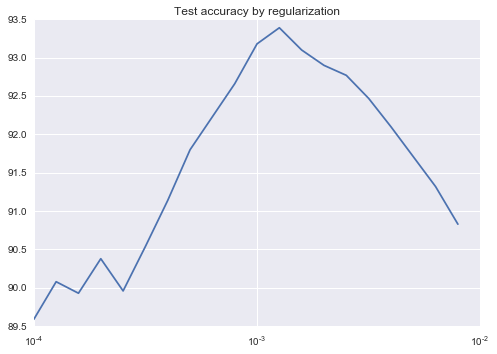

In [10]:
plt.semilogx(regul_val, acc_val)
plt.grid(True)
plt.title('Test accuracy by regularization')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [11]:
batch_size = 128
hidden_nums = 1024   #[Hidden layers nums]

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  para_regul = tf.placeholder(tf.float32)  
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nums]))
  biases = tf.Variable(tf.zeros([hidden_nums]))
    
  # Hidden computation
  hidden_input = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
  # Hidden Variables  
  hidden_weight = tf.Variable(
    tf.truncated_normal([hidden_nums, num_labels]))
  hidden_biases = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits = tf.matmul(hidden_input, hidden_weight) + hidden_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), hidden_weight) + hidden_biases)   
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), hidden_weight) + hidden_biases)

In [12]:
num_steps = 501
train_size = 1024

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_size - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 406.192017
Minibatch accuracy: 12.5%
Validation accuracy: 31.2%
Minibatch loss at step 50: 19.237749
Minibatch accuracy: 96.9%
Validation accuracy: 73.4%
Minibatch loss at step 100: 0.000011
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Minibatch loss at step 150: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 200: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 250: 0.000002
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 300: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 350: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 400: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 450: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.6%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accur

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
batch_size = 128
hidden_nums = 1024   #[Hidden layers nums]

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  para_regul = tf.placeholder(tf.float32)  
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nums]))
  biases = tf.Variable(tf.zeros([hidden_nums]))
    
  # Hidden computation
  hidden_input = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases),0.5)
    
  # Hidden Variables  
  hidden_weight = tf.Variable(
    tf.truncated_normal([hidden_nums, num_labels]))
  hidden_biases = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits = tf.matmul(hidden_input, hidden_weight) + hidden_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), hidden_weight) + hidden_biases)   
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), hidden_weight) + hidden_biases)

In [14]:
num_steps = 501
train_size = 1024

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_size - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 432.381958
Minibatch accuracy: 10.2%
Validation accuracy: 30.2%
Minibatch loss at step 50: 3.112052
Minibatch accuracy: 96.1%
Validation accuracy: 77.4%
Minibatch loss at step 100: 12.195364
Minibatch accuracy: 93.0%
Validation accuracy: 77.7%
Minibatch loss at step 150: 5.106567
Minibatch accuracy: 96.9%
Validation accuracy: 79.0%
Minibatch loss at step 200: 2.473001
Minibatch accuracy: 96.9%
Validation accuracy: 79.3%
Minibatch loss at step 250: 5.107832
Minibatch accuracy: 97.7%
Validation accuracy: 78.8%
Minibatch loss at step 300: 0.000126
Minibatch accuracy: 100.0%
Validation accuracy: 79.2%
Minibatch loss at step 350: 0.132940
Minibatch accuracy: 99.2%
Validation accuracy: 79.6%
Minibatch loss at step 400: 1.507009
Minibatch accuracy: 97.7%
Validation accuracy: 79.4%
Minibatch loss at step 450: 0.723428
Minibatch accuracy: 98.4%
Validation accuracy: 78.8%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [15]:
batch_size = 128
hidden_nums = 1024   #[Hidden layers nums]

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  para_regul = tf.placeholder(tf.float32)  
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  global_step = tf.Variable(0)  
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)  
    
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nums]))
  biases = tf.Variable(tf.zeros([hidden_nums]))
    
  # Hidden computation
  hidden_input = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    
  # Hidden Variables  
  hidden_weight = tf.Variable(
    tf.truncated_normal([hidden_nums, num_labels]))
  hidden_biases = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits = tf.matmul(hidden_input, hidden_weight) + hidden_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + para_regul * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(hidden_weight))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), hidden_weight) + hidden_biases)   
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), hidden_weight) + hidden_biases)

In [16]:
num_steps = 12001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, para_regul: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 650.437256
Minibatch accuracy: 8.6%
Validation accuracy: 28.6%
Minibatch loss at step 500: 196.340942
Minibatch accuracy: 82.0%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 116.125763
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 81.834709
Minibatch accuracy: 87.5%
Validation accuracy: 83.3%
Minibatch loss at step 2000: 58.695717
Minibatch accuracy: 89.1%
Validation accuracy: 84.5%
Minibatch loss at step 2500: 47.505424
Minibatch accuracy: 88.3%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 38.575928
Minibatch accuracy: 83.6%
Validation accuracy: 85.6%
Minibatch loss at step 3500: 33.764740
Minibatch accuracy: 85.9%
Validation accuracy: 86.1%
Minibatch loss at step 4000: 29.296043
Minibatch accuracy: 89.1%
Validation accuracy: 86.1%
Minibatch loss at step 4500: 26.886030
Minibatch accuracy: 86.7%
Validation accuracy: 86.5%
Minibatch loss at step 5000: 24.608055
Minibatch accuracy: 89.8%
Valid

### multi-layer neural network model

In [17]:
batch_size = 128
hidden1_nums = 1024
hidden2_nums = 256
hidden3_nums = 128
keep_rate = 0.5

def weight_var(layer_num1,layer_num2):
    return tf.Variable(tf.truncated_normal([layer_num1, layer_num2], stddev=np.sqrt(2.0 / layer_num1)))

def bias_var(layer_nums):
    return tf.Variable(tf.zeros([layer_nums]))

def compute_logits(input_data, weightss, biasess, dropout_vals=None):  
    temp = input_data  
    if dropout_vals:  
        for w,b,d in zip(weightss[:-1], biasess[:-1], dropout_vals[:-1]):  
            temp = tf.nn.relu_layer(tf.nn.dropout(temp, d), w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    else:  
        for w,b in zip(weightss[:-1], biasess[:-1]): 
            temp = tf.nn.relu_layer(temp, w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    return temp 

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = weight_var(image_size * image_size, hidden1_nums)  
  biases1 = bias_var(hidden1_nums)
  weights2 = weight_var(hidden1_nums, hidden2_nums)
  biases2 = bias_var(hidden2_nums)
  weights3 = weight_var(hidden2_nums, hidden3_nums)
  biases3 = bias_var(hidden3_nums)
  weights4 = weight_var(hidden3_nums, num_labels)
  biases4 = bias_var(num_labels)
  
  # Training computation.
  logits = compute_logits(tf_train_dataset, [weights1, weights2, weights3,weights4], [biases1,biases2,biases3,biases4],   
                            dropout_vals=(1.0,0.95,0.95,0.95,1.0))  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(compute_logits(tf_valid_dataset, [weights1, weights2, weights3,weights4], [biases1,biases2,biases3,biases4]))
  test_prediction = tf.nn.softmax(compute_logits(tf_test_dataset, [weights1, weights2, weights3,weights4], [biases1,biases2,biases3,biases4]))

In [18]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.358826
Minibatch accuracy: 7.8%
Validation accuracy: 19.5%
Minibatch loss at step 2000: 0.253241
Minibatch accuracy: 93.0%
Validation accuracy: 88.5%
Minibatch loss at step 4000: 0.281373
Minibatch accuracy: 92.2%
Validation accuracy: 89.4%
Minibatch loss at step 6000: 0.396009
Minibatch accuracy: 87.5%
Validation accuracy: 90.2%
Minibatch loss at step 8000: 0.406676
Minibatch accuracy: 86.7%
Validation accuracy: 90.3%
Minibatch loss at step 10000: 0.188852
Minibatch accuracy: 94.5%
Validation accuracy: 90.6%
Minibatch loss at step 12000: 0.204013
Minibatch accuracy: 93.8%
Validation accuracy: 90.7%
Minibatch loss at step 14000: 0.240203
Minibatch accuracy: 91.4%
Validation accuracy: 91.2%
Minibatch loss at step 16000: 0.090496
Minibatch accuracy: 98.4%
Validation accuracy: 91.1%
Minibatch loss at step 18000: 0.058926
Minibatch accuracy: 98.4%
Validation accuracy: 91.4%
Minibatch loss at step 20000: 0.179576
Minibatch accuracy: 93.8%
Validation a